In [8]:
from keras.applications import inception_v3
from keras.applications import vgg16
from keras import backend as K

# We will not be training our model,
# so we use this command to disable all training-specific operations
K.set_learning_phase(0)

# Build the InceptionV3 network.
# The model will be loaded with pre-trained ImageNet weights.
# model = inception_v3.InceptionV3(weights='imagenet',
#                                  include_top=False)
model = vgg16.VGG16(weights='imagenet', include_top=False)

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [10]:
# Dict mapping layer names to a coefficient
# quantifying how much the layer's activation
# will contribute to the loss we will seek to maximize.
# Note that these are layer names as they appear
# in the built-in InceptionV3 application.
# You can list all layer names using `model.summary()`.
layer_contributions = {
    'block2_conv2': 0.2,
    'block3_conv3': 6.,
    'block4_conv3': 10.,
    'block5_conv3': 4.,
}

In [11]:
#  Get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# Define the loss.
loss = K.variable(0.)
for layer_name in layer_contributions:
    # Add the L2 norm of the features of a layer to the loss.
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output

    # We avoid border artifacts by only involving non-border pixels in the loss.
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    loss += coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

In [12]:
# This holds our generated image
dream = model.input

# Compute the gradients of the dream with regard to the loss.
grads = K.gradients(loss, dream)[0]

# Normalize gradients.
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

# Set up function to retrieve the value
# of the loss and gradients given an input image.
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

In [13]:
import scipy
from keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)


def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Processing image shape (110, 166)
...Loss value at 0 : 625.4035
...Loss value at 1 : 737.32916
...Loss value at 2 : 849.04016
...Loss value at 3 : 956.83435
...Loss value at 4 : 1056.7864
...Loss value at 5 : 1154.1678
...Loss value at 6 : 1246.2861
...Loss value at 7 : 1340.6051
...Loss value at 8 : 1432.5444
...Loss value at 9 : 1527.6051
...Loss value at 10 : 1623.5846
...Loss value at 11 : 1722.3375
...Loss value at 12 : 1823.9893
...Loss value at 13 : 1925.8157
...Loss value at 14 : 2030.4647
...Loss value at 15 : 2135.4688
...Loss value at 16 : 2244.0
...Loss value at 17 : 2354.3682
...Loss value at 18 : 2465.5466
...Loss value at 19 : 2579.1953
...Loss value at 20 : 2700.3108
...Loss value at 21 : 2821.0261
...Loss value at 22 : 2947.8186
...Loss value at 23 : 3071.2537
...Loss value at 24 : 3207.0647
...Loss value at 25 : 3337.96
...Loss value at 26 : 3480.0706
...Loss value at 27 : 3618.8499
...Loss value at 28 : 3764.2893
...Loss value at 29 : 3912.3347


/Users/ericsmith/anaconda/envs/MachineLearning/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  from ipykernel import kernelapp as app


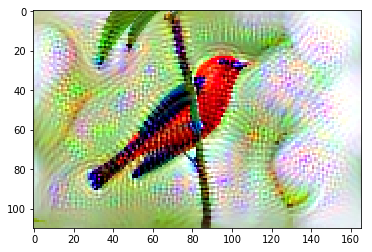

Processing image shape (155, 233)


/Users/ericsmith/anaconda/envs/MachineLearning/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


...Loss value at 0 : 1806.2695
...Loss value at 1 : 2027.8586
...Loss value at 2 : 2229.9573
...Loss value at 3 : 2413.3525
...Loss value at 4 : 2585.9387
...Loss value at 5 : 2753.6445
...Loss value at 6 : 2917.127
...Loss value at 7 : 3082.8047
...Loss value at 8 : 3241.3337
...Loss value at 9 : 3404.8298
...Loss value at 10 : 3566.3572
...Loss value at 11 : 3730.408
...Loss value at 12 : 3899.0254
...Loss value at 13 : 4070.721
...Loss value at 14 : 4249.7036
...Loss value at 15 : 4432.798
...Loss value at 16 : 4620.8027
...Loss value at 17 : 4812.023
...Loss value at 18 : 5011.7964
...Loss value at 19 : 5212.4976
...Loss value at 20 : 5424.6035
...Loss value at 21 : 5641.03
...Loss value at 22 : 5861.511
...Loss value at 23 : 6087.991
...Loss value at 24 : 6325.1895
...Loss value at 25 : 6568.3477
...Loss value at 26 : 6822.672
...Loss value at 27 : 7079.6265
...Loss value at 28 : 7347.739
...Loss value at 29 : 7621.839


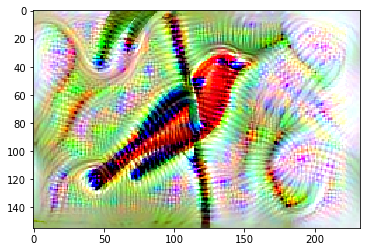

Processing image shape (217, 326)
...Loss value at 0 : 3619.3015
...Loss value at 1 : 3915.4426
...Loss value at 2 : 4190.912
...Loss value at 3 : 4448.9565
...Loss value at 4 : 4700.114
...Loss value at 5 : 4946.707
...Loss value at 6 : 5192.8364
...Loss value at 7 : 5441.0635
...Loss value at 8 : 5692.34
...Loss value at 9 : 5949.507
...Loss value at 10 : 6212.6987
...Loss value at 11 : 6480.1685
...Loss value at 12 : 6755.6543
...Loss value at 13 : 7038.4966
...Loss value at 14 : 7331.792
...Loss value at 15 : 7632.4067
...Loss value at 16 : 7943.6987
...Loss value at 17 : 8263.712
...Loss value at 18 : 8592.578
...Loss value at 19 : 8934.806
...Loss value at 20 : 9283.846
...Loss value at 21 : 9646.19
...Loss value at 22 : 10018.868
...Loss value at 23 : 10404.517
...Loss value at 24 : 10803.535
...Loss value at 25 : 11213.16
...Loss value at 26 : 11635.3955
...Loss value at 27 : 12071.513
...Loss value at 28 : 12521.366
...Loss value at 29 : 12984.988


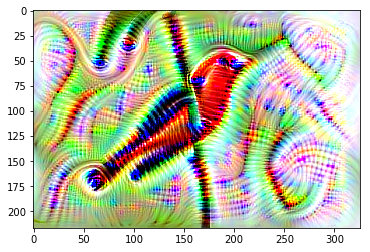

Processing image shape (304, 457)
...Loss value at 0 : 6373.297
...Loss value at 1 : 6774.99
...Loss value at 2 : 7174.9517
...Loss value at 3 : 7573.493
...Loss value at 4 : 7972.951
...Loss value at 5 : 8377.146
...Loss value at 6 : 8788.03
...Loss value at 7 : 9208.1875
...Loss value at 8 : 9639.316
...Loss value at 9 : 10082.519
...Loss value at 10 : 10538.332
...Loss value at 11 : 11006.896
...Loss value at 12 : 11490.319
...Loss value at 13 : 11988.301
...Loss value at 14 : 12502.696
...Loss value at 15 : 13032.817
...Loss value at 16 : 13580.128
...Loss value at 17 : 14144.716
...Loss value at 18 : 14727.062
...Loss value at 19 : 15329.418
...Loss value at 20 : 15950.598
...Loss value at 21 : 16593.87
...Loss value at 22 : 17260.16
...Loss value at 23 : 17949.715
...Loss value at 24 : 18661.242
...Loss value at 25 : 19396.732
...Loss value at 26 : 20153.082
...Loss value at 27 : 20936.873
...Loss value at 28 : 21741.143
...Loss value at 29 : 22573.69


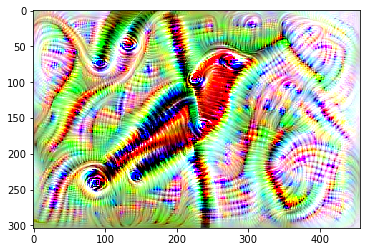

Processing image shape (426, 640)
...Loss value at 0 : 11007.639
...Loss value at 1 : 11602.644
...Loss value at 2 : 12219.846
...Loss value at 3 : 12850.1875
...Loss value at 4 : 13492.194
...Loss value at 5 : 14148.957
...Loss value at 6 : 14823.325
...Loss value at 7 : 15517.108
...Loss value at 8 : 16230.09
...Loss value at 9 : 16964.328
...Loss value at 10 : 17722.21
...Loss value at 11 : 18501.324
...Loss value at 12 : 19305.771
...Loss value at 13 : 20135.121
...Loss value at 14 : 20992.977
...Loss value at 15 : 21878.918
...Loss value at 16 : 22792.422
...Loss value at 17 : 23739.883
...Loss value at 18 : 24718.562
...Loss value at 19 : 25730.582
...Loss value at 20 : 26778.703
...Loss value at 21 : 27860.787
...Loss value at 22 : 28976.967
...Loss value at 23 : 30128.184
...Loss value at 24 : 31317.727
...Loss value at 25 : 32545.002
...Loss value at 26 : 33809.223
...Loss value at 27 : 35108.906
...Loss value at 28 : 36449.2
...Loss value at 29 : 37830.652


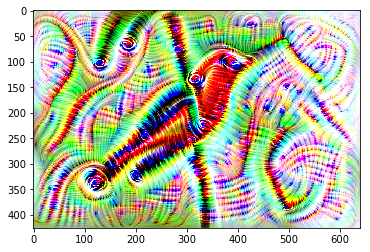

In [14]:
import numpy as np
from matplotlib import pyplot as plt


# Playing with these hyperparameters will also allow you to achieve new effects

step = 0.01  # Gradient ascent step size
num_octave = 5  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 30  # Number of ascent steps per scale

# If our loss gets larger than 10,
# we will interrupt the gradient ascent process, to avoid ugly artifacts
max_loss = None

# Fill this to the path to the image you want to use
base_image_path = 'bird.jpg'

# Load the image into a Numpy array
img = preprocess_image(base_image_path)

# We prepare a list of shape tuples
# defining the different scales at which we will run gradient ascent
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

# Reverse list of shapes, so that they are in increasing order
successive_shapes = successive_shapes[::-1]

# Resize the Numpy array of the image to our smallest scale
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    
    
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='bird_at_scale_' + str(shape) + '.png')
    plt.imshow(deprocess_image(np.copy(img)))
    plt.show()


save_img(img, fname='final_dream.png')


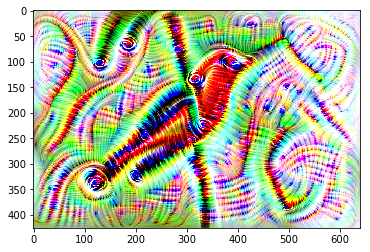

In [15]:
from matplotlib import pyplot as plt

plt.imshow(deprocess_image(np.copy(img)))
plt.show()

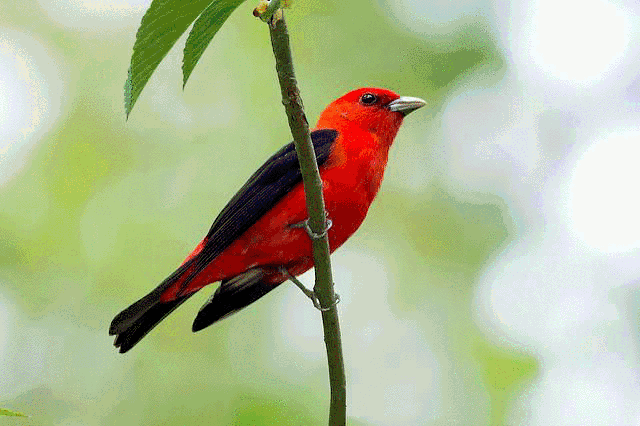

In [17]:
from IPython.display import Image
with open('./Images/animated_bird.gif','rb') as f:
    display(Image(data=f.read(), format='png'))